***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [2]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

In [3]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [4]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [5]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [6]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (46771, 4195)


In [7]:
df['url_number_vowels'] = df['domain'].str.lower().str.count(r'[aeiou]')
df['url_number_consonants'] = df['domain'].str.count(r'[bcdfghjklmnpqrstvwxzy]', flags=re.I)
df['url_number_digits'] = df['domain'].str.count(r'\d')
df['url_number_special_chars']=df['url_length']-df[['url_number_vowels','url_number_consonants','url_number_digits']].sum(axis=1)

In [8]:
df['url_port']=df['url_port'].apply(lambda x: 0 if x==0 else 1 )

In [9]:
# characters='abcdefghijklmnopqrstuvwxyz0123456789'
# for char in characters:
#     field=char+"_average"
#     df[field]=df['domain'].apply(lambda x: str.count(x, char))
#     df[field]=df[field]/df['url_length']

In [10]:
df.set_index(['domain'],inplace=True,drop=True)

In [11]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [12]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
# display(np.array(col_no_unique))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

302 columns have only one unique value in them rendering them meaningless for classification


In [13]:
print("Shape of our dataset after dropping them:",df.shape)

ext_end=[col for col in df.columns if 'extension_ends' in col]

for col in ext_end:
    df[col]=df[col].astype(int)

# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)
print("Columns which are of type object:\n",df.dtypes[(df.dtypes=='object')])

lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)

Shape of our dataset after dropping them: (46771, 3896)
Columns which are of type object:
 url_contains_signin    object
url_contains_www       object
url_host               object
url_ip                 object
dtype: object


In [14]:
print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()
col_values['95_%_same_values'].value_counts()

3846 columns have more than 95% same values


True     3846
False      49
Name: 95_%_same_values, dtype: int64

In [15]:
print("Columns which are of type object:",df[columns].dtypes[(df.dtypes=='object')])
columns.remove('url_host')

rem=['url_tld_NET','url_tld_COM','url_tld_NE','url_tld_CO','url_extension_endswith_.com', 'url_extension_.c']
for col in rem:
    columns.remove(col)

df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Columns which are of type object: url_host    object
dtype: object
Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
url_extension_.com,-0.154316,4.061880e-247,-34.113589,9.926271e-241
url_extension_.i,-0.005769,2.122020e-01,-1.243880,2.135748e-01
url_char_m,-0.000765,8.685861e-01,-0.133716,8.936303e-01
url_char_o,0.074650,8.715169e-59,12.338724,1.155801e-34
url_char_j,0.116675,1.984745e-141,16.725416,1.082992e-61
url_char_v,0.105337,1.682865e-115,17.027650,6.949488e-64
url_char_c,0.110988,4.385017e-128,17.136575,1.205077e-64
url_char_g,0.119543,2.045127e-148,20.120991,6.796065e-88
url_char_-,0.188291,0.000000e+00,22.532080,1.071961e-108



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,
url_extension_.net,138.8931,0.0,0.0545


In [16]:
fin_col=columns
fin_col

['Target',
 'url_char_-',
 'url_char_.',
 'url_char_a',
 'url_char_b',
 'url_char_c',
 'url_char_d',
 'url_char_e',
 'url_char_f',
 'url_char_g',
 'url_char_h',
 'url_char_i',
 'url_char_j',
 'url_char_k',
 'url_char_l',
 'url_char_m',
 'url_char_n',
 'url_char_o',
 'url_char_p',
 'url_char_r',
 'url_char_s',
 'url_char_t',
 'url_char_u',
 'url_char_v',
 'url_char_w',
 'url_char_x',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extension_.i',
 'url_extension_.net',
 'url_extensions',
 'url_length',
 'url_tlds',
 'url_words_with_length_4',
 'url_words_with_length_5',
 'url_words_with_length_6',
 'url_words_with_length_7',
 'url_words_with_length_8',
 'url_number_vowels',
 'url_number_consonants',
 'url_number_digits']

In [17]:
train=df_sel.iloc[:32740,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[32740:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [18]:
columns=fin_col

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [19]:
columns.remove('Target')

In [20]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [21]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9634697617593159
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27848    59    27907
True        1137  3696     4833
__all__    28985  3755    32740

Accuracy of the model for test data is: 0.9579502530111895
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11942    28    11970
True         562  1499     2061
__all__    12504  1527    14031



Logistic Regression
Accuracy of the model for training data is: 0.951038485033598
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27558   349    27907
True        1254  3579     4833
__all__    28812  3928    32740

Accuracy of the model for test data is: 0.9522485924025372
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11811   159    11970
True         511  1550     2061
__all__    12322  1709    14031



RandomForest Classifier
Accuracy of the model for training data is: 0.9941356139279169
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27904     3    27907
True         189  4644     4833
__all__    28093  4647    32740

Accuracy of the model for test data is: 0.9635806428622337
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11879    91    11970
True         420  1641     2061
__all__    12299  1732    14031



Adaoost Classifier
Accuracy of the model for training data is: 0.9486866218692731
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27506   401    27907
True        1279  3554     4833
__all__    28785  3955    32740

Accuracy of the model for test data is: 0.9475447224003991
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11789   181    11970
True         555  1506     2061
__all__    12344  1687    14031



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9605070250458155
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27617   290    27907
True        1003  3830     4833
__all__    28620  4120    32740

Accuracy of the model for test data is: 0.9588055021024874
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11834   136    11970
True         442  1619     2061
__all__    12276  1755    14031



ExtraTree Classifier
Accuracy of the model for training data is: 1.0
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27907     0    27907
True           0  4833     4833
__all__    27907  4833    32740

Accuracy of the model for test data is: 0.9642933504383152
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11903    67    11970
True         434  1627     2061
__all__    12337  1694    14031



Bagging Classifier
Accuracy of the model for training data is: 0.9942577886377519
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27901     6    27907
True         182  4651     4833
__all__    28083  4657    32740

Accuracy of the model for test data is: 0.9635806428622337
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11864   106    11970
True         405  1656     2061
__all__    12269  1762    14031



Neural Network-1
The accuracy of the model on training data is: 0.9972816127061698


Predicted  False  True  __all__
Actual                         
False      27902     5    27907
True          84  4749     4833
__all__    27986  4754    32740

The accuracy of the model on test data is: 0.9508944480079823


Predicted  False  True  __all__
Actual                         
False      11666   304    11970
True         385  1676     2061
__all__    12051  1980    14031

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [22]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [23]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.963470,3696.0,27848.0,59.0,1137.0,0.002114,0.235258
LogisticRegression,0.951038,3579.0,27558.0,349.0,1254.0,0.012506,0.259466
RandomForestClassifier,0.994136,4644.0,27904.0,3.0,189.0,0.000107,0.039106
AdaBoostClassifier,0.948687,3554.0,27506.0,401.0,1279.0,0.014369,0.264639
GradientBoostingClassifier,0.960507,3830.0,27617.0,290.0,1003.0,0.010392,0.207532
ExtraTreeClassifier,1.000000,4833.0,27907.0,0.0,0.0,0.000000,0.000000
BaggingClassifier,0.994258,4651.0,27901.0,6.0,182.0,0.000215,0.037658
Neural Network-1,0.997282,4749.0,27902.0,5.0,84.0,0.000179,0.017381


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.957950,1499.0,11942.0,28.0,562.0,0.002339,0.272683,0.862489,0.824075
LogisticRegression,0.952249,1550.0,11811.0,159.0,511.0,0.013283,0.247938,0.869389,0.799630
RandomForestClassifier,0.963581,1641.0,11879.0,91.0,420.0,0.007602,0.203785,0.894307,0.848675
AdaBoostClassifier,0.947545,1506.0,11789.0,181.0,555.0,0.015121,0.269287,0.857796,0.778872
GradientBoostingClassifier,0.958806,1619.0,11834.0,136.0,442.0,0.011362,0.214459,0.887090,0.828439
ExtraTreeClassifier,0.964293,1627.0,11903.0,67.0,434.0,0.005597,0.210577,0.891913,0.851616
BaggingClassifier,0.963581,1656.0,11864.0,106.0,405.0,0.008855,0.196507,0.897319,0.848883
Neural Network-1,0.950894,1676.0,11666.0,304.0,385.0,0.025397,0.186803,0.893900,0.801047


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [24]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [25]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

In [26]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [27]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9753287705593578
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26550   1357    27907
True          20  27887    27907
__all__    26570  29244    55814

Accuracy of the model for test data is: 0.918680065569097
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11111   859    11970
True         282  1779     2061
__all__    11393  2638    14031



Logistic Regression
Accuracy of the model for training data is: 0.89674633604472
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25915   1992    27907
True        3771  24136    27907
__all__    29686  26128    55814

Accuracy of the model for test data is: 0.9218159789038557
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11119   851    11970
True         246  1815     2061
__all__    11365  2666    14031



RandomForest Classifier
Accuracy of the model for training data is: 0.9979933350055542
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27905      2    27907
True         110  27797    27907
__all__    28015  27799    55814

Accuracy of the model for test data is: 0.9625828522557195
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11838   132    11970
True         393  1668     2061
__all__    12231  1800    14031



Adaoost Classifier
Accuracy of the model for training data is: 0.9388146343211381
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26594   1313    27907
True        2102  25805    27907
__all__    28696  27118    55814

Accuracy of the model for test data is: 0.9314375311809564
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11370   600    11970
True         362  1699     2061
__all__    11732  2299    14031



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9649191959006701
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27196    711    27907
True        1247  26660    27907
__all__    28443  27371    55814

Accuracy of the model for test data is: 0.9489701375525622
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11634   336    11970
True         380  1681     2061
__all__    12014  2017    14031



ExtraTree Classifier
Accuracy of the model for training data is: 1.0
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27907      0    27907
True           0  27907    27907
__all__    27907  27907    55814

Accuracy of the model for test data is: 0.9648635164991803
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11862   108    11970
True         385  1676     2061
__all__    12247  1784    14031



Bagging Classifier
Accuracy of the model for training data is: 0.9971691690256925
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27898      9    27907
True         149  27758    27907
__all__    28047  27767    55814

Accuracy of the model for test data is: 0.9621552277100706
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11836   134    11970
True         397  1664     2061
__all__    12233  1798    14031



Neural Network-1
The accuracy of the model on training data is: 0.9986562511197907


Predicted  False   True  __all__
Actual                          
False      27874     33    27907
True          42  27865    27907
__all__    27916  27898    55814

The accuracy of the model on test data is: 0.9462618487634523


Predicted  False  True  __all__
Actual                         
False      11568   402    11970
True         352  1709     2061
__all__    11920  2111    14031

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [28]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [29]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.975329,27887.0,26550.0,1357.0,20.0,0.048626,0.000717
LogisticRegression,0.896746,24136.0,25915.0,1992.0,3771.0,0.071380,0.135127
RandomForestClassifier,0.997993,27797.0,27905.0,2.0,110.0,0.000072,0.003942
AdaBoostClassifier,0.938815,25805.0,26594.0,1313.0,2102.0,0.047049,0.075322
GradientBoostingClassifier,0.964919,26660.0,27196.0,711.0,1247.0,0.025477,0.044684
ExtraTreeClassifier,1.000000,27907.0,27907.0,0.0,0.0,0.000000,0.000000
BaggingClassifier,0.997169,27758.0,27898.0,9.0,149.0,0.000322,0.005339
Neural Network-1,0.998656,27865.0,27874.0,33.0,42.0,0.001182,0.001505


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.918680,1779.0,11111.0,859.0,282.0,0.071763,0.136827,0.895705,0.717020
LogisticRegression,0.921816,1815.0,11119.0,851.0,246.0,0.071094,0.119360,0.904773,0.730488
RandomForestClassifier,0.962583,1668.0,11838.0,132.0,393.0,0.011028,0.190684,0.899144,0.845043
AdaBoostClassifier,0.931438,1699.0,11370.0,600.0,362.0,0.050125,0.175643,0.887116,0.740460
GradientBoostingClassifier,0.948970,1681.0,11634.0,336.0,380.0,0.028070,0.184377,0.893777,0.794638
ExtraTreeClassifier,0.964864,1676.0,11862.0,108.0,385.0,0.009023,0.186803,0.902087,0.854524
BaggingClassifier,0.962155,1664.0,11836.0,134.0,397.0,0.011195,0.192625,0.898090,0.843211
Neural Network-1,0.946262,1709.0,11568.0,402.0,352.0,0.033584,0.170791,0.897813,0.787793


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [30]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [31]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (9666, 41)


In [32]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [33]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9157872956755638
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4741    92     4833
True         722  4111     4833
__all__     5463  4203     9666

Accuracy of the model for test data is: 0.9482574299764807
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11622   348    11970
True         378  1683     2061
__all__    12000  2031    14031



Logistic Regression
Accuracy of the model for training data is: 0.8961307676391476
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4480   353     4833
True         651  4182     4833
__all__     5131  4535     9666

Accuracy of the model for test data is: 0.9225286864799372
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11146   824    11970
True         263  1798     2061
__all__    11409  2622    14031



RandomForest Classifier
Accuracy of the model for training data is: 0.9903786468032278
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4824     9     4833
True          84  4749     4833
__all__     4908  4758     9666

Accuracy of the model for test data is: 0.9392773145178533
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11384   586    11970
True         266  1795     2061
__all__    11650  2381    14031



Adaoost Classifier
Accuracy of the model for training data is: 0.8942685702462239
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4454   379     4833
True         643  4190     4833
__all__     5097  4569     9666

Accuracy of the model for test data is: 0.9095574085952534
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10959  1011    11970
True         258  1803     2061
__all__    11217  2814    14031



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9077177736395613
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4581   252     4833
True         640  4193     4833
__all__     5221  4445     9666

Accuracy of the model for test data is: 0.9312949896657401
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11275   695    11970
True         269  1792     2061
__all__    11544  2487    14031



ExtraTree Classifier
Accuracy of the model for training data is: 1.0
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4833     0     4833
True           0  4833     4833
__all__     4833  4833     9666

Accuracy of the model for test data is: 0.9367828380015679
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11352   618    11970
True         269  1792     2061
__all__    11621  2410    14031



Bagging Classifier
Accuracy of the model for training data is: 0.9899648251603559
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4824     9     4833
True          88  4745     4833
__all__     4912  4754     9666

Accuracy of the model for test data is: 0.9324353217874706
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11308   662    11970
True         286  1775     2061
__all__    11594  2437    14031



Neural Network-1
The accuracy of the model on training data is: 0.9982412580177943


Predicted  False  True  __all__
Actual                         
False       4833     0     4833
True          17  4816     4833
__all__     4850  4816     9666

The accuracy of the model on test data is: 0.9039270187442092


Predicted  False  True  __all__
Actual                         
False      10865  1105    11970
True         243  1818     2061
__all__    11108  2923    14031

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [34]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [35]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.915787,4111.0,4741.0,92.0,722.0,0.019036,0.149390
LogisticRegression,0.896131,4182.0,4480.0,353.0,651.0,0.073040,0.134699
RandomForestClassifier,0.990379,4749.0,4824.0,9.0,84.0,0.001862,0.017381
AdaBoostClassifier,0.894269,4190.0,4454.0,379.0,643.0,0.078419,0.133044
GradientBoostingClassifier,0.907718,4193.0,4581.0,252.0,640.0,0.052142,0.132423
ExtraTreeClassifier,1.000000,4833.0,4833.0,0.0,0.0,0.000000,0.000000
BaggingClassifier,0.989965,4745.0,4824.0,9.0,88.0,0.001862,0.018208
Neural Network-1,0.998241,4816.0,4833.0,0.0,17.0,0.000000,0.003517


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.948257,1683.0,11622.0,348.0,378.0,0.029073,0.183406,0.893761,0.792324
LogisticRegression,0.922529,1798.0,11146.0,824.0,263.0,0.068839,0.127608,0.901777,0.729727
RandomForestClassifier,0.939277,1795.0,11384.0,586.0,266.0,0.048956,0.129064,0.910990,0.775184
AdaBoostClassifier,0.909557,1803.0,10959.0,1011.0,258.0,0.084461,0.125182,0.895178,0.698729
GradientBoostingClassifier,0.931295,1792.0,11275.0,695.0,269.0,0.058062,0.130519,0.905710,0.752169
ExtraTreeClassifier,0.936783,1792.0,11352.0,618.0,269.0,0.051629,0.130519,0.908926,0.767592
BaggingClassifier,0.932435,1775.0,11308.0,662.0,286.0,0.055305,0.138768,0.902964,0.753074
Neural Network-1,0.903927,1818.0,10865.0,1105.0,243.0,0.092314,0.117904,0.894891,0.688432


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [36]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [37]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [38]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 3321 features
EntitySet scattered to workers in 4.721 seconds
Elapsed: 00:20 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [39]:
df.set_index(['domain'],drop=True,inplace=True)

In [40]:
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [41]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [42]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [43]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [55]:
feature_name=['url_char_w * url_extensions',
 'url_length + url_words_with_length_7',
 'url_length + url_tlds',
 'url_extension_.com / url_char_.',
 'url_extension_.com + url_length',
 'url_char_y + url_length',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_z',
 'url_char_v + url_length',
 'url_char_u + url_length',
 'url_char_s + url_length',
 'url_char_r + url_length',
 'url_char_o + url_length',
 'url_char_m + url_length',
 'url_char_l + url_length',
 'url_char_k + url_length',
 'url_char_k + url_extensions',
 'url_char_j + url_length',
 'url_char_i + url_length',
 'url_char_h + url_length',
 'url_char_g + url_length',
 'url_char_f + url_length',
 'url_char_e + url_length',
 'url_char_c + url_length',
 'url_char_b + url_length',
 'url_char_a + url_length',
 'url_char_. + url_length',
 'url_char_. + url_char_z',
 'url_char_. + url_char_w',
 'url_char_. + url_char_j',
 'url_char_.',
 'url_char_- + url_length']

In [56]:
X=fs[feature_name]
X.fillna(value=0,inplace=True)
y=fs.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 33)

In [57]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_char_w * url_extensions',
 'url_length + url_words_with_length_7',
 'url_length + url_tlds',
 'url_extension_.com / url_char_.',
 'url_extension_.com + url_length',
 'url_char_y + url_length',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_z',
 'url_char_v + url_length',
 'url_char_u + url_length',
 'url_char_s + url_length',
 'url_char_r + url_length',
 'url_char_o + url_length',
 'url_char_m + url_length',
 'url_char_l + url_length',
 'url_char_k + url_length',
 'url_char_k + url_extensions',
 'url_char_j + url_length',
 'url_char_i + url_length',
 'url_char_h + url_length',
 'url_char_g + url_length',
 'url_char_f + url_length',
 'url_char_e + url_length',
 'url_char_c + url_length',
 'url_char_b + url_length',
 'url_char_a + url_length',
 'url_char_. + url_length',
 'url_char_. + url_char_z',
 'url_char_. + url_char_w',
 'url_char_. + url_char_j',
 'url_char_.',
 'url_char_- + url_length']

In [58]:
fs=fs.reindex(df_sel.index.values)

In [59]:
train=fs.iloc[:32740]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32740:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [60]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [61]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9610262675626146
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27606   301    27907
True         975  3858     4833
__all__    28581  4159    32740

Accuracy of the model for test data is: 0.9532463830090514
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11773   197    11970
True         459  1602     2061
__all__    12232  1799    14031



Logistic Regression
Accuracy of the model for training data is: 0.9430665852168602
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27494   413    27907
True        1451  3382     4833
__all__    28945  3795    32740

Accuracy of the model for test data is: 0.9421281448221794
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11780   190    11970
True         622  1439     2061
__all__    12402  1629    14031



RandomForest Classifier
Accuracy of the model for training data is: 0.9934941967012828
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27900     7    27907
True         206  4627     4833
__all__    28106  4634    32740

Accuracy of the model for test data is: 0.956809920889459
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11824   146    11970
True         460  1601     2061
__all__    12284  1747    14031



Adaoost Classifier
Accuracy of the model for training data is: 0.9423946243127672
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27471   436    27907
True        1450  3383     4833
__all__    28921  3819    32740

Accuracy of the model for test data is: 0.9394198560330697
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11760   210    11970
True         640  1421     2061
__all__    12400  1631    14031



GradientBoosting Classifier
Accuracy of the model for training data is: 0.951435552840562
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27496   411    27907
True        1179  3654     4833
__all__    28675  4065    32740

Accuracy of the model for test data is: 0.9497541158862519
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11775   195    11970
True         510  1551     2061
__all__    12285  1746    14031



ExtraTree Classifier
Accuracy of the model for training data is: 0.9998472816127062
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27907     0    27907
True           5  4828     4833
__all__    27912  4828    32740

Accuracy of the model for test data is: 0.9542441736155656
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11809   161    11970
True         481  1580     2061
__all__    12290  1741    14031



Bagging Classifier
Accuracy of the model for training data is: 0.9934331093463653
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27899     8    27907
True         207  4626     4833
__all__    28106  4634    32740

Accuracy of the model for test data is: 0.95445798588839
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11794   176    11970
True         463  1598     2061
__all__    12257  1774    14031



Neural Network-1
The accuracy of the model on training data is: 0.9649358582773366


Predicted  False  True  __all__
Actual                         
False      27679   228    27907
True         920  3913     4833
__all__    28599  4141    32740

The accuracy of the model on test data is: 0.9606585418002993


Predicted  False  True  __all__
Actual                         
False      11841   129    11970
True         423  1638     2061
__all__    12264  1767    14031

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [62]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [63]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.961026,3858.0,27606.0,301.0,975.0,0.010786,0.201738
LogisticRegression,0.943067,3382.0,27494.0,413.0,1451.0,0.014799,0.300228
RandomForestClassifier,0.993494,4627.0,27900.0,7.0,206.0,0.000251,0.042624
AdaBoostClassifier,0.942395,3383.0,27471.0,436.0,1450.0,0.015623,0.300021
GradientBoostingClassifier,0.951436,3654.0,27496.0,411.0,1179.0,0.014727,0.243948
ExtraTreeClassifier,0.999847,4828.0,27907.0,0.0,5.0,0.000000,0.001035
BaggingClassifier,0.993433,4626.0,27899.0,8.0,207.0,0.000287,0.042831
Neural Network-1,0.964936,3913.0,27679.0,228.0,920.0,0.008170,0.190358


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.953246,1602.0,11773.0,197.0,459.0,0.016458,0.222707,0.880417,0.805586
LogisticRegression,0.942128,1439.0,11780.0,190.0,622.0,0.015873,0.301795,0.841166,0.754007
RandomForestClassifier,0.956810,1601.0,11824.0,146.0,460.0,0.012197,0.223193,0.882305,0.819804
AdaBoostClassifier,0.939420,1421.0,11760.0,210.0,640.0,0.017544,0.310529,0.835964,0.742114
GradientBoostingClassifier,0.949754,1551.0,11775.0,195.0,510.0,0.016291,0.247453,0.868128,0.789597
ExtraTreeClassifier,0.954244,1580.0,11809.0,161.0,481.0,0.013450,0.233382,0.876584,0.808728
BaggingClassifier,0.954458,1598.0,11794.0,176.0,463.0,0.014703,0.224648,0.880324,0.810217
Neural Network-1,0.960659,1638.0,11841.0,129.0,423.0,0.010777,0.205240,0.891991,0.836485


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [64]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [65]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

distributed.core - INFO - Event loop was unresponsive in Nanny for 44.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 44.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 44.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 44.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 44.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

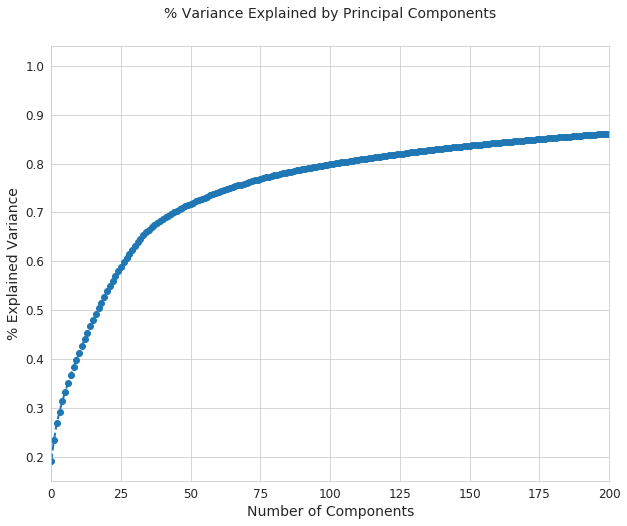

In [66]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [69]:
pca=PCA(n_components=110,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 110 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 110 components is: 0.8066180588518638


In [70]:
X_train=X_pca_21[:32740]
Y_train=fs.iloc[:32740]['Target'].values
X_test=X_pca_21[32740:]
Y_test=fs.iloc[32740:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [71]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,110).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9481979230299328
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27876    31    27907
True        1665  3168     4833
__all__    29541  3199    32740

Accuracy of the model for test data is: 0.9394911267906778
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11956    14    11970
True         835  1226     2061
__all__    12791  1240    14031



Logistic Regression
Accuracy of the model for training data is: 0.9548259010384851
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27539   368    27907
True        1111  3722     4833
__all__    28650  4090    32740

Accuracy of the model for test data is: 0.9560972133133775
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11822   148    11970
True         468  1593     2061
__all__    12290  1741    14031



RandomForest Classifier
Accuracy of the model for training data is: 0.9934636530238241
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27904     3    27907
True         211  4622     4833
__all__    28115  4625    32740

Accuracy of the model for test data is: 0.9416292495189224
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11818   152    11970
True         667  1394     2061
__all__    12485  1546    14031



Adaoost Classifier
Accuracy of the model for training data is: 0.9437996334758705
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27398   509    27907
True        1331  3502     4833
__all__    28729  4011    32740

Accuracy of the model for test data is: 0.9452640581569383
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11759   211    11970
True         557  1504     2061
__all__    12316  1715    14031



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9569028711056812
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27668   239    27907
True        1172  3661     4833
__all__    28840  3900    32740

Accuracy of the model for test data is: 0.9531751122514432
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11823   147    11970
True         510  1551     2061
__all__    12333  1698    14031



ExtraTree Classifier
Accuracy of the model for training data is: 1.0
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27907     0    27907
True           0  4833     4833
__all__    27907  4833    32740

Accuracy of the model for test data is: 0.9342170907276744
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11878    92    11970
True         831  1230     2061
__all__    12709  1322    14031



Bagging Classifier
Accuracy of the model for training data is: 0.9930054978619426
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27900     7    27907
True         222  4611     4833
__all__    28122  4618    32740

Accuracy of the model for test data is: 0.9481148884612643
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11808   162    11970
True         566  1495     2061
__all__    12374  1657    14031



Neural Network-1
The accuracy of the model on training data is: 0.9989920586438608


Predicted  False  True  __all__
Actual                         
False      27890    17    27907
True          16  4817     4833
__all__    27906  4834    32740

The accuracy of the model on test data is: 0.9549568811916471


Predicted  False  True  __all__
Actual                         
False      11717   253    11970
True         379  1682     2061
__all__    12096  1935    14031

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [72]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [73]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.948198,3168.0,27876.0,31.0,1665.0,0.001111,0.344507
LogisticRegression,0.954826,3722.0,27539.0,368.0,1111.0,0.013187,0.229878
RandomForestClassifier,0.993464,4622.0,27904.0,3.0,211.0,0.000107,0.043658
AdaBoostClassifier,0.943800,3502.0,27398.0,509.0,1331.0,0.018239,0.275398
GradientBoostingClassifier,0.956903,3661.0,27668.0,239.0,1172.0,0.008564,0.242499
ExtraTreeClassifier,1.000000,4833.0,27907.0,0.0,0.0,0.000000,0.000000
BaggingClassifier,0.993005,4611.0,27900.0,7.0,222.0,0.000251,0.045934
Neural Network-1,0.998992,4817.0,27890.0,17.0,16.0,0.000609,0.003311


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.939491,1226.0,11956.0,14.0,835.0,0.001170,0.405143,0.796844,0.740424
LogisticRegression,0.956097,1593.0,11822.0,148.0,468.0,0.012364,0.227074,0.880281,0.816667
RandomForestClassifier,0.941629,1394.0,11818.0,152.0,667.0,0.012698,0.323629,0.831836,0.750310
AdaBoostClassifier,0.945264,1504.0,11759.0,211.0,557.0,0.017627,0.270257,0.856058,0.769608
GradientBoostingClassifier,0.953175,1551.0,11823.0,147.0,510.0,0.012281,0.247453,0.870133,0.803473
ExtraTreeClassifier,0.934217,1230.0,11878.0,92.0,831.0,0.007686,0.403202,0.794556,0.713859
BaggingClassifier,0.948115,1495.0,11808.0,162.0,566.0,0.013534,0.274624,0.855921,0.780825
Neural Network-1,0.954957,1682.0,11717.0,253.0,379.0,0.021136,0.183891,0.897486,0.816163


In [74]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')